# Analysis of customers orders data

For python code please refer https://github.com/pranaymallipudi/stoutcases/blob/main/insights_casestudy2

In [230]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import os
import warnings
import matplotlib.patches as mpatches
warnings.filterwarnings("ignore")



- The dataset contains information about customer orders. It has 3 important columns.
    - Customer_email: email id of customer. Unique in a given year
    - net_revenue: net revenue generated from each customer in a given year
    - year: year from which data is from
- Dataset has 685,927 observations

### Read the raw data

In [231]:
raw = pd.read_csv('casestudy.csv',index_col = 0)

In [232]:
raw.head()

,customer_email,net_revenue,year
0,nhknapwsbx@gmail.com,249.92,2015
1,joiuzbvcpn@gmail.com,87.61,2015
2,ukkjctepxt@gmail.com,168.38,2015
3,gykatilzrt@gmail.com,62.40,2015
4,mmsgsrtxah@gmail.com,43.08,2015


In [233]:
total_rev = raw.groupby(['year']).agg({'net_revenue':['sum','mean']})

In [234]:
total_rev.columns = [total_rev.columns[0][0]+'_'+total_rev.columns[0][1],\
                     total_rev.columns[1][0]+'_'+total_rev.columns[1][1]]

total_rev.reset_index(inplace = True)

#### Total revenue fluctuated but not average per customer

- We can see from below graph, that total revenue decreased from 2015-2016 and then increased from 2016-2017 but there is no significant difference from average revenue per customer

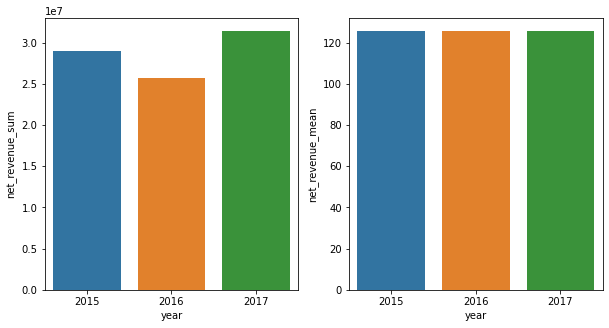

In [235]:
fig,axes = plt.subplots(1,2,figsize=(10,5))
sns.barplot(ax = axes[0],data=total_rev,x='year',y='net_revenue_sum')
sns.barplot(ax = axes[1],data=total_rev,x='year',y='net_revenue_mean')
plt.show()

#### No outliers and skewness

- Box plot shows that there are no unusual values in the net_revenue that might be causing the same average across years
- As these box plots are very similar to each, let's see how overall distribution of net_revenue looks like

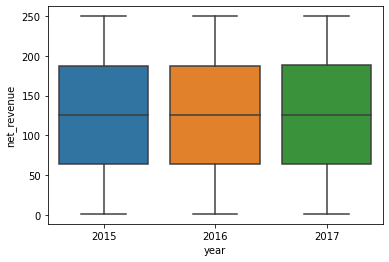

In [236]:
sns.boxplot(data=raw,y='net_revenue',x="year")
plt.show()

- Distribution plot shows almost uniform distribution of net_income

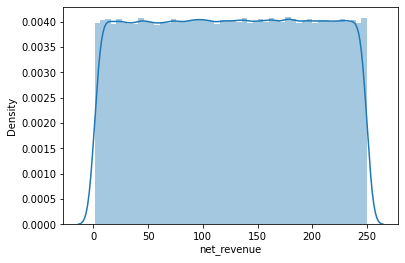

In [237]:
sns.distplot(raw['net_revenue'])
plt.show()

#### Let's see how many loyal customers do we have. Loyalty is defined by customers who are with across across years

- As we can see from below graph number of customers who continued with us across years are very less
    - About 90% of customers are one time customers

In [238]:
rep_cust = raw.groupby('customer_email')['customer_email'].count().value_counts(normalize=True)*100

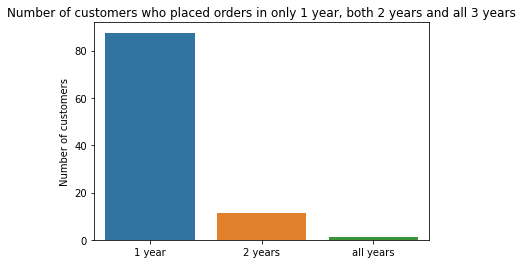

In [239]:
sns.barplot(x=rep_cust.index,y=rep_cust.values)
plt.xticks([0,1,2],labels = ['1 year','2 years','all years'])
plt.title('Number of customers who placed orders in only 1 year, both 2 years and all 3 years')
plt.ylabel('Number of customers')
plt.show()

### Now let's do basic EDA on dataset

#### Check data types

In [240]:
print(raw.shape)
print(raw.dtypes)

(685927, 3)
customer_email     object
net_revenue       float64
year                int64
dtype: object


#### Describe the dataset

In [241]:
raw.describe(include='all')

,customer_email,net_revenue,year
count,685927,"685,927.00","685,927.00"
unique,604618,NaN,NaN
top,qficxgsahc@gmail.com,NaN,NaN
freq,3,NaN,NaN
mean,NaN,125.65,"2,016.03"
std,NaN,71.85,0.84
min,NaN,1.00,"2,015.00"
25%,NaN,63.51,"2,015.00"
50%,NaN,125.73,"2,016.00"
75%,NaN,187.82,"2,017.00"


#### Check for missing values in the dataset

- No missing values in the dataset

In [242]:
raw.isnull().mean()

customer_email   0.00
net_revenue      0.00
year             0.00
dtype: float64

### 1. total revenue for the current year

In [243]:
revenue_by_year = raw.groupby('year')[['net_revenue']].sum().reset_index()

In [244]:
#revenue_by_year

In [245]:

for i in revenue_by_year.index:
     print(f'The revenue for {revenue_by_year.year[i]} is {revenue_by_year.net_revenue[i]:.2f}' )

The revenue for 2015 is 29036749.19
The revenue for 2016 is 25730943.59
The revenue for 2017 is 31417495.03


In [246]:
##using cross tab method
#pd.crosstab(raw.year,raw.net_revenue,values = raw.net_revenue,aggfunc='sum',margins='index')[['All']]

### 2.New Customer Revenue 

Logic: 
- Get new customers by removing all the email ids in current year which are also present in previous year

In [247]:
new_cust_a = pd.DataFrame(columns = ['year','net_revenue'])
for i in range(1,len(raw.year.unique())):
    cust_uniq_curyear = list(raw[raw['year']==raw.year.unique()[i]].customer_email.unique())
    cust_uniq_prevyear = list(raw[raw['year']==raw.year.unique()[i-1]].customer_email.unique())
    new_cust = list(set(cust_uniq_curyear)-set(cust_uniq_prevyear))
    new_cust_df = raw[(raw['year']==raw.year.unique()[i]) & (raw['customer_email'].isin(new_cust))]\
    .groupby('year')[['net_revenue']].sum().reset_index()
    print(f'The new customer revenue from year {raw.year.unique()[i]} is {new_cust_df.net_revenue[0]:.2f}' )
    new_cust_a = new_cust_a.append(new_cust_df,ignore_index=True)
new_cust_a.rename(columns = {'net_revenue':'new_cust_revenue'},inplace=True)

The new customer revenue from year 2016 is 18245491.01
The new customer revenue from year 2017 is 28776235.04


### 3.Existing Customer Growth

Logic: 
- Existing customers are customers from last year who are also present in this year
- Filter above customers in previous year to get customers who continued till next year
- Get the revenue of same customer set from both current and previous years and take the difference


In [248]:
growth_df_a = pd.DataFrame()
for i in range(1,len(raw.year.unique())):
    cust_uniq_prevyear = list(raw[raw['year']==raw.year.unique()[i-1]].customer_email.unique())
    exist_cust_curyear_df = raw[(raw['year']==raw.year.unique()[i])&(raw['customer_email'].isin(cust_uniq_prevyear))]
    rev_exist_cust_curyear = exist_cust_curyear_df.groupby('year')[['net_revenue']].sum().reset_index()

    exist_cust_prevyear_df = raw[(raw['year']==raw.year.unique()[i-1]) &(raw['customer_email'].\
                                                      isin(list(exist_cust_curyear_df.customer_email.unique()))) ]
    rev_exist_cust_prevyear = exist_cust_prevyear_df.groupby('year')[['net_revenue']].sum().reset_index()

    growth = rev_exist_cust_curyear['net_revenue'][0]-rev_exist_cust_prevyear['net_revenue'][0]
    growth_df = pd.DataFrame({'year':[raw.year.unique()[i]],'exist_cust_growth':[growth],\
                             'current_revenue_exist_cust':[rev_exist_cust_curyear['net_revenue'][0]],\
                              'prev_revenue_exist_cust':[rev_exist_cust_prevyear['net_revenue'][0]]})
    growth_df_a = growth_df_a.append(growth_df,ignore_index=True)
    print(f'The existing customer growth from {raw.year.unique()[i-1]} to {raw.year.unique()[i]} is {growth:.2f}' )


The existing customer growth from 2015 to 2016 is 20335.46
The existing customer growth from 2016 to 2017 is 20611.34


### 4.Revenue lost from attrition
Logic
- Total revenue of customers from previous year who didn't continue in current year
- We assume that they would have generated same revenue in current year if they had continued
- Since they didn't continue we can say that we lost the amount of revenue which is equal to amount of revenue they generated in previous year

In [249]:
lost_cust_a = pd.DataFrame(columns = ['year','net_revenue'])
for i in range(1,len(raw.year.unique())):
    cust_uniq_curyear = list(raw[raw['year']==raw.year.unique()[i]].customer_email.unique())
    cust_uniq_prevyear = list(raw[raw['year']==raw.year.unique()[i-1]].customer_email.unique())
    lost_cust = list(set(cust_uniq_prevyear)-set(cust_uniq_curyear))
    lost_cust_df = raw[(raw['year']==raw.year.unique()[i-1]) & (raw['customer_email'].isin(lost_cust))]\
    .groupby('year')[['net_revenue']].sum().reset_index()
    lost_cust_df.iloc[0,0] = lost_cust_df.iloc[0,0]+1
    print(f"Revenue lost from attrition in year {raw.year.unique()[i]},i.e the customers who didn't continue from {raw.year.unique()[i-1]}  is {lost_cust_df.net_revenue[0]:.2f}" )
    lost_cust_a = lost_cust_a.append(lost_cust_df,ignore_index=True)
lost_cust_a.rename(columns = {'net_revenue':'lost_cust_revenue'},inplace=True)


Revenue lost from attrition in year 2016,i.e the customers who didn't continue from 2015  is 21571632.07
Revenue lost from attrition in year 2017,i.e the customers who didn't continue from 2016  is 23110294.94


### 5.Existing Customer Revenue Current Year & 6.Existing Customer Revenue Prior Year

Logic
- Existing customer revenue current year: Revenue of customers who continued from past year to current
- Existing customer revenue prior year: Revenue of same above customers but in past year

In [250]:
for i in range(1,len(raw.year.unique())):
    cust_uniq_prevyear = list(raw[raw['year']==raw.year.unique()[i-1]].customer_email.unique())
    exist_cust_curyear_df = raw[(raw['year']==raw.year.unique()[i])&(raw['customer_email'].isin(cust_uniq_prevyear))]
    rev_exist_cust_curyear = exist_cust_curyear_df.groupby('year')[['net_revenue']].sum().reset_index()

    exist_cust_prevyear_df = raw[(raw['year']==raw.year.unique()[i-1]) &(raw['customer_email'].\
                                                      isin(list(exist_cust_curyear_df.customer_email.unique()))) ]
    rev_exist_cust_prevyear = exist_cust_prevyear_df.groupby('year')[['net_revenue']].sum().reset_index()

    growth = rev_exist_cust_curyear['net_revenue'][0]-rev_exist_cust_prevyear['net_revenue'][0]
    print(f"The existing customer revenue in current year {raw.year.unique()[i]}  is {rev_exist_cust_curyear['net_revenue'][0]:.2f}")
    print(f"The existing customer revenue in previous year {raw.year.unique()[i-1]}  is {rev_exist_cust_prevyear['net_revenue'][0]:.2f}" )

The existing customer revenue in current year 2016  is 7485452.58
The existing customer revenue in previous year 2015  is 7465117.12
The existing customer revenue in current year 2017  is 2641259.99
The existing customer revenue in previous year 2016  is 2620648.65


### 7.Total Customers Current Year

In [251]:
#raw.groupby(['year']).agg({'year':'count','customer_email':'count'})

In [252]:
total_cust = raw.groupby(['year'])[['customer_email']].count().reset_index()
total_cust.rename(columns = {'customer_email':'total_customers'},inplace = True)
for i in range(len(total_cust)):
    print(f'Total customers in {total_cust.iloc[i,0]} is {total_cust.iloc[i,1]}')

Total customers in 2015 is 231294
Total customers in 2016 is 204646
Total customers in 2017 is 249987


### 8.Total customers previous year

In [253]:
#total_cust = raw.groupby(['year'])[['customer_email']].count().reset_index()
for i in range(1,len(total_cust)):
    print(f'Total customers in {total_cust.iloc[i-1,0]} which is previous year to {total_cust.iloc[i,0]} is {total_cust.iloc[i-1,1]}')

Total customers in 2015 which is previous year to 2016 is 231294
Total customers in 2016 which is previous year to 2017 is 204646


### 9.New customers

In [254]:
new_cust_count_a = pd.DataFrame(columns = ['year','new_customers'])
for i in range(1,len(raw.year.unique())):
    cust_uniq_curyear = list(raw[raw['year']==raw.year.unique()[i]].customer_email.unique())
    cust_uniq_prevyear = list(raw[raw['year']==raw.year.unique()[i-1]].customer_email.unique())
    new_cust = len(list(set(cust_uniq_curyear)-set(cust_uniq_prevyear)))
    new_cust_df = pd.DataFrame({'year':[raw.year.unique()[i]],'new_customers':[new_cust]})
    print(f'The new customers in year {raw.year.unique()[i]} is {new_cust}' )
    new_cust_count_a = new_cust_count_a.append(new_cust_df,ignore_index=True)

The new customers in year 2016 is 145062
The new customers in year 2017 is 229028


### 10.Lost Customers

In [255]:
lost_cust_count_a = pd.DataFrame(columns = ['year','lost_customers'])
for i in range(1,len(raw.year.unique())):
    cust_uniq_curyear = list(raw[raw['year']==raw.year.unique()[i]].customer_email.unique())
    cust_uniq_prevyear = list(raw[raw['year']==raw.year.unique()[i-1]].customer_email.unique())
    lost_cust = len(list(set(cust_uniq_prevyear)-set(cust_uniq_curyear)))
    lost_cust_df = pd.DataFrame({'year':[raw.year.unique()[i]],'lost_customers':[lost_cust]})
    print(f"The customers we lost in year {raw.year.unique()[i]},i.e customers who didn't continue from {raw.year.unique()[i-1]} are {lost_cust}" )
    lost_cust_count_a = lost_cust_count_a.append(lost_cust_df,ignore_index=True)

The customers we lost in year 2016,i.e customers who didn't continue from 2015 are 171710
The customers we lost in year 2017,i.e customers who didn't continue from 2016 are 183687


### Visualizations

In [256]:
# revenue_by_year
# new_cust_a
# lost_cust_a
# total_cust
# new_cust_count_a
# lost_cust_count_a
year = pd.DataFrame({'year':[2015,2016,2017]})
summ = year.merge(revenue_by_year,on='year',how = 'left').\
            merge(new_cust_a,on='year',how = 'left').\
            merge(growth_df_a,on='year',how = 'left').\
            merge(lost_cust_a,on='year',how = 'left').\
            merge(total_cust,on='year',how = 'left').\
            merge(new_cust_count_a,on='year',how = 'left').\
            merge(lost_cust_count_a,on='year',how = 'left')



In [257]:
summ.fillna(0,inplace=True)
summ.loc[summ["year"] == 2015, "current_revenue_exist_cust"] = summ.loc[summ["year"] == 2015, "net_revenue"]

In [258]:
summ['existing_cust'] = summ['total_customers']-summ['new_customers']

In [259]:
summ

,year,net_revenue,new_cust_revenue,exist_cust_growth,current_revenue_exist_cust,prev_revenue_exist_cust,lost_cust_revenue,total_customers,new_customers,lost_customers,existing_cust
0,2015,"29,036,749.19",0.00,0.00,"29,036,749.19",0.00,0.00,231294,0,0,231294
1,2016,"25,730,943.59","18,245,491.01","20,335.46","7,485,452.58","7,465,117.12","21,571,632.07",204646,145062,171710,59584
2,2017,"31,417,495.03","28,776,235.04","20,611.34","2,641,259.99","2,620,648.65","23,110,294.94",249987,229028,183687,20959


#### Let's see how our customer retention and customer acquisition is:

- Below bar graph represents:
    - Light blue: existing customers from previous year only
    - Dark blue: new customers
- As we can see, our customer retention is very poor across the years while our strength seems to be new customer acquisition
- Growth in number of customers in 2017 is mostly caused by new customers
- Generally, customer retention is more easy and cost effective while customer acquisition can be a expensive process
- So we should come up with strategies for customer retention


- Since the average revenue from customers across years is same, the revenue is only affected by number of customers. More the customers, more the revenue

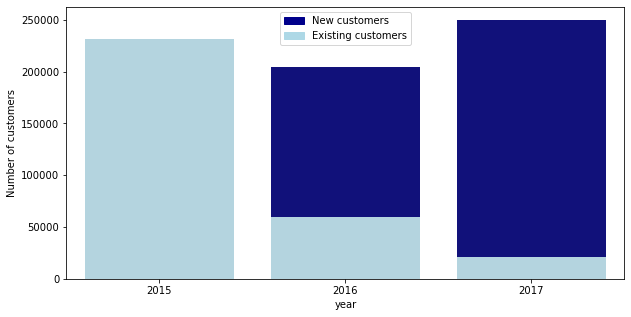

In [260]:
# bar chart 1 
plt.figure(figsize = (10,5))
bar1 = sns.barplot(x="year",  y="total_customers", data=summ, color='darkblue')

bar2 = sns.barplot(x="year", y="existing_cust", data=summ,color='lightblue')

#add legend
top_bar = mpatches.Patch(color='darkblue', label='New customers')
bottom_bar = mpatches.Patch(color='lightblue', label='Existing customers')
plt.legend(handles=[top_bar, bottom_bar])
plt.ylabel('Number of customers')

plt.show()

In [261]:
os.system('jupyter nbconvert --to html Insights_casestudy2.ipynb --no-input')


0